In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

- U-Net 是一种常用于图像分割的深度学习架构，特别适用于医学图像分割等任务。


![Screenshot 2023-12-27 095112.png](<attachment:Screenshot 2023-12-27 095112.png>)
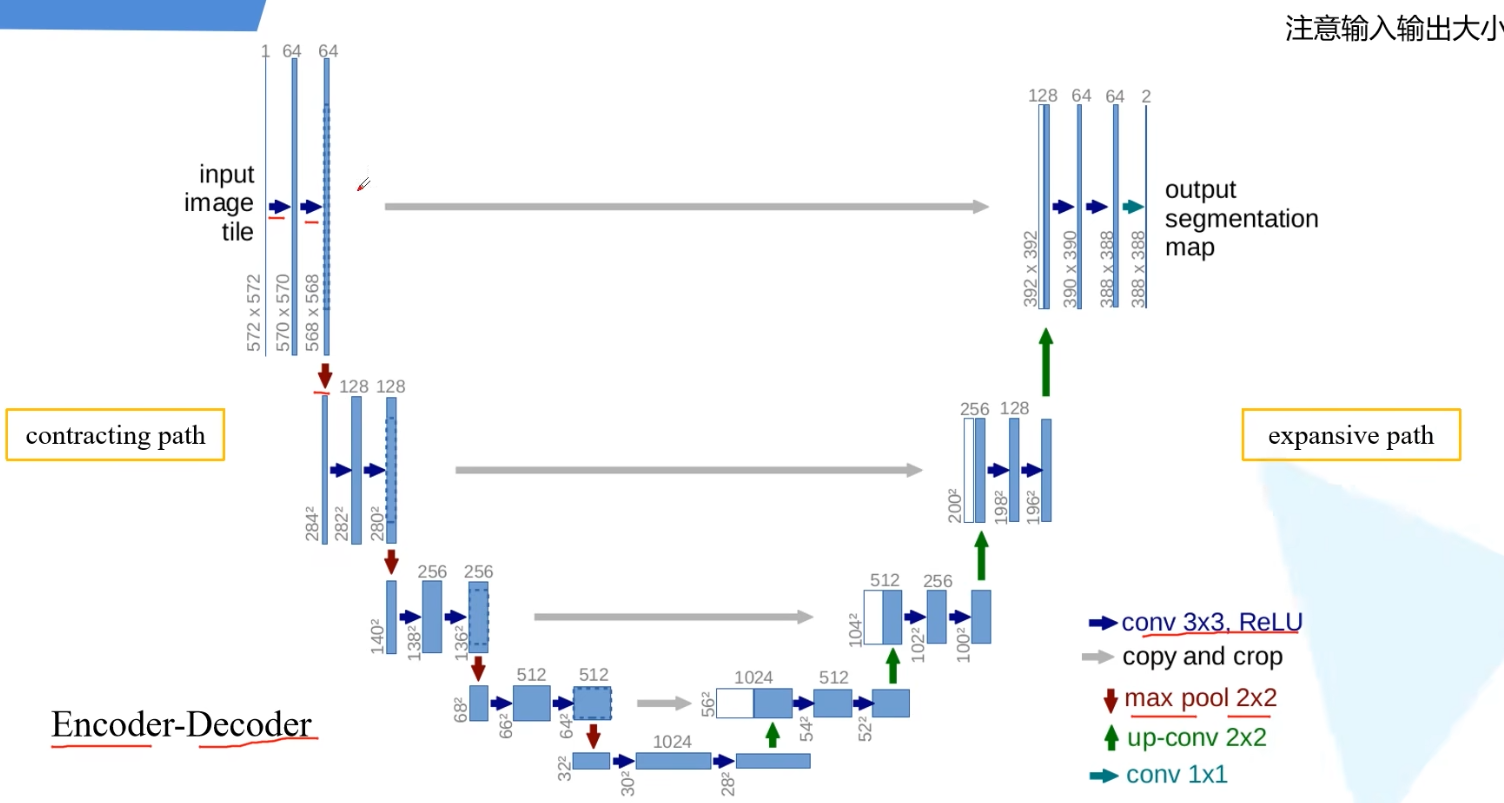

In [6]:
# 卷积层，第二个卷积通道不变
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.conv1 = DoubleConv(in_channels, 64)    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64, 128)
        self.conv3 = DoubleConv(128, 256)
        self.conv4 = DoubleConv(256, 512)
        self.conv5 = DoubleConv(512, 1024)
        
        self.up_conv6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up_conv7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up_conv8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up_conv9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # --- 下采样，编码阶段
        conv1 = self.conv1(x) # 通道设置为64
        x = self.pool(conv1)  

        conv2 = self.conv2(x)
        x = self.pool(conv2)

        conv3 = self.conv3(x)
        x = self.pool(conv3)

        conv4 = self.conv4(x)
        x = self.pool(conv4)

        x = self.conv5(x)

        # --- 上采样阶段，解码阶段
        x = self.up_conv6(x)
        x = torch.cat([x, conv4], dim=1)
        
        x = self.conv6(x)
        x = self.up_conv7(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.conv7(x)
        x = self.up_conv8(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.conv8(x)
        x = self.up_conv9(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.conv9(x)
        
        x = self.out(x)
        return x

In [12]:
net = UNet(3, 3)
inp = torch.rand(1, 3, 512, 512)
outp = net(inp)
display(outp.shape)

torch.Size([1, 3, 512, 512])